# Manual Bacterial Cell Stage Annotator

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tifffile
import numpy as np
from IPython.display import clear_output

In [2]:
# Load the DataFrame
df = pd.read_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/cleanned_data.csv')

/tmp/ipykernel_1938981/1331675221.py:2: DtypeWarning: Columns (1127) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/cleanned_data.csv')


In [3]:
# Ensure matplotlib is set for Jupyter
%matplotlib inline

# Function to normalize a single channel
def normalize_channel(channel):
    # Use 2nd and 98th percentiles to handle outliers
    low, high = np.percentile(channel, [2, 98])
    if high == low:
        return channel / channel.max() if channel.max() > 0 else channel
    channel = np.clip(channel, low, high)
    channel_min = channel.min()
    channel_max = channel.max()
    if channel_max == channel_min:
        return channel / channel.max() if channel.max() > 0 else channel
    return (channel - channel_min) / (channel_max - channel_min)

# Function to overlay 4 channels into an RGB image
def overlay_channels(img):
    # Expect img shape: (height, width, 4)
    if img.shape[-1] != 4:
        raise ValueError(f"Expected 4 channels, got {img.shape[-1]}")
    
    # Normalize each channel
    channels = [normalize_channel(img[:, :, i]) for i in range(4)]
    
    # Initialize RGB image
    rgb = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.float32)
    
    # Assign colors: Channel 1 (Red), Channel 2 (Green), Channel 3 (Blue), Channel 4 (Magenta)
    rgb[:, :, 0] = channels[0]  # Red
    rgb[:, :, 1] = channels[1]  # Green
    rgb[:, :, 2] = channels[2]  # Blue
    rgb[:, :, 0] += channels[3] * 0.5  # Magenta (red component)
    rgb[:, :, 2] += channels[3] * 0.5  # Magenta (blue component)
    
    # Clip to [0, 1]
    rgb = np.clip(rgb, 0, 1)
    
    return rgb

### TODO:
- Add selection of batch group functionality

Available Labels:
1: Mutant
0: Wild Type


Enter the label to annotate (0 for Wild Type, 1 for Mutant):  0



Available Batches for Wild Type:
1. 181213
2. 190421


Enter the numbers of the Batches to annotate (e.g., 1,3 or 'all' for all batches, or press Enter to finish):  1
Do you want to select more batches? (yes/no):  no



Available Groups for Batch 181213 (Label: Wild Type):
1. 2
2. 3
3. 1
4. 4


Enter the numbers of the Groups to annotate for Batch 181213 (e.g., 1,3 or 'all' for all groups, or press Enter to finish):  2
Do you want to select more groups for Batch 181213? (yes/no):  no



Image: 1/20 
Batch: 181213 
Group: 3 (Wild Type)
File: /scratch/leuven/359/vsc35907/feature_extraction_data/patches3/wild_type/181213-mg aczv 003 m9lalaxy02_28.tif



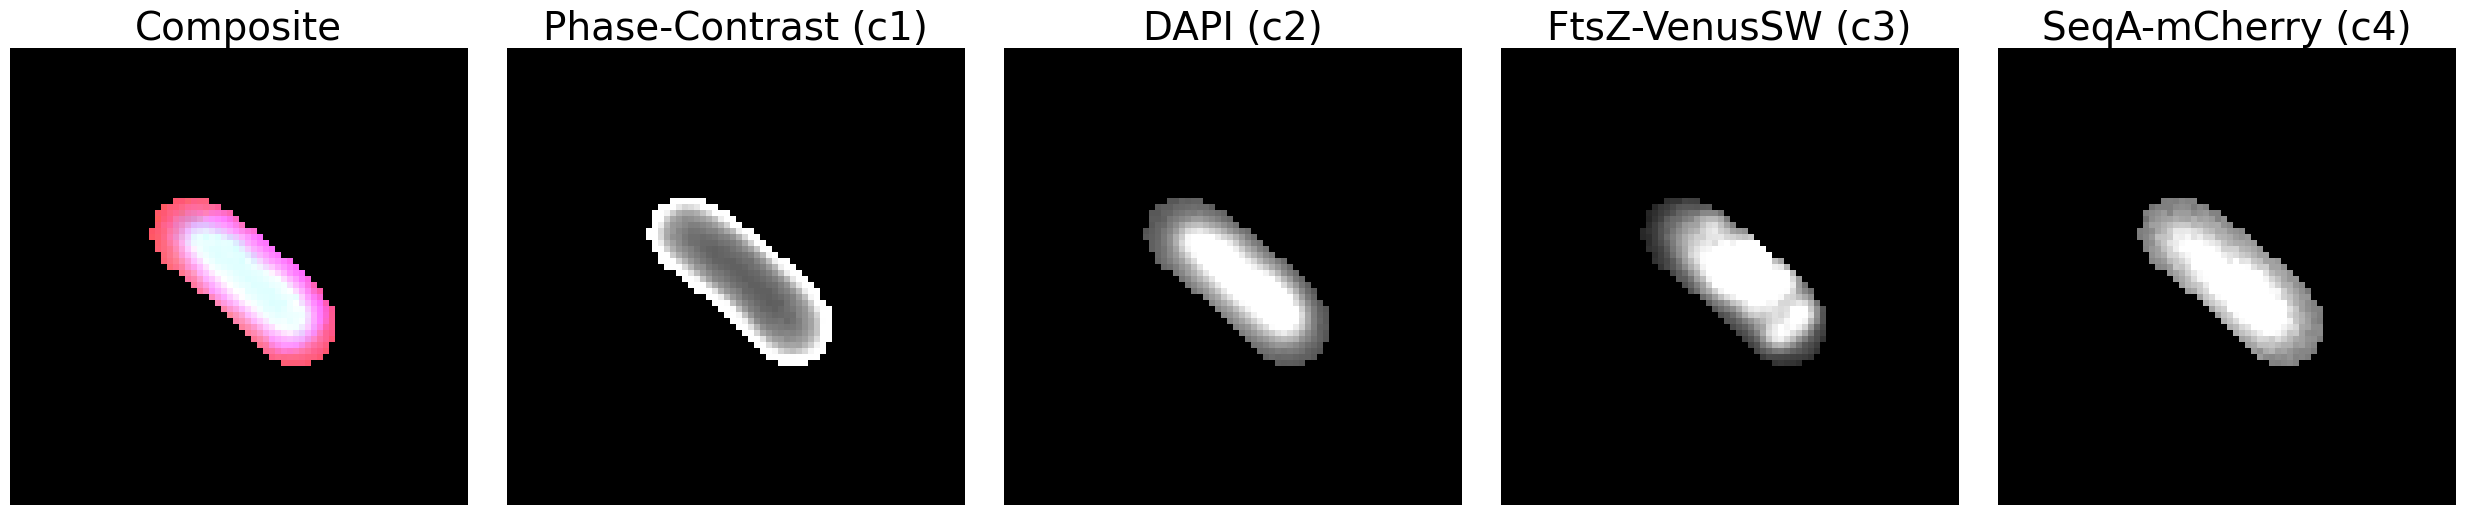

In [ ]:
# Initialize a dictionary to store cell_stage for each sample (using index as key)
cell_stage_dict = {}

# Step 1: Select label
print("Available Labels:")
labels = df['label'].unique()
label_map = {0: 'Wild Type', 1: 'Mutant'}
for label in labels:
    print(f"{label}: {label_map[label]}")

while True:
    try:
        label_input = input("Enter the label to annotate (0 for Wild Type, 1 for Mutant): ").strip()
        if label_input not in ['0', '1']:
            print("Invalid input. Please enter 0 or 1.")
            continue
        selected_label = int(label_input)
        break
    except ValueError:
        print("Invalid input. Please enter 0 or 1.")

# Step 2: Select batch for the chosen label
batches = df[df['label'] == selected_label]['batch'].unique()
if len(batches) == 0:
    print(f"No batches available for label {label_map[selected_label]}. Exiting annotation.")
else:
    print(f"\nAvailable Batches for {label_map[selected_label]}:")
    for idx, batch in enumerate(batches, 1):
        print(f"{idx}. {batch}")

    selected_batches = []
    while True:
        try:
            prompt = f"Enter the numbers of the Batches to annotate (e.g., 1,3 or 'all' for all batches, or press Enter to finish): "
            user_input = input(prompt).strip()
            
            if user_input.lower() == 'all':
                selected_batches = list(batches)
                break
            elif user_input == '':
                break
            
            # Parse comma-separated numbers
            indices = [int(i.strip()) - 1 for i in user_input.split(',') if i.strip().isdigit()]
            if not indices:
                print("No valid numbers entered. Please try again.")
                continue
                
            # Validate indices
            invalid_indices = [i for i in indices if i < 0 or i >= len(batches)]
            if invalid_indices:
                print(f"Invalid indices: {[i + 1 for i in invalid_indices]}. Please select numbers between 1 and {len(batches)}.")
                continue
                
            selected_batches.extend([batches[i] for i in indices])
            prompt_continue = "Do you want to select more batches? (yes/no): "
            if input(prompt_continue).strip().lower() in ['no', 'n']:
                break
                
        except ValueError:
            print("Invalid input. Please enter numbers separated by commas or 'all'.")
            continue

    # Remove duplicates and sort
    selected_batches = sorted(list(set(selected_batches)))

    # Step 3: For each selected batch, select groups
    selected_pairs = []
    for batch in selected_batches:
        groups = df[(df['label'] == selected_label) & (df['batch'] == batch)]['group'].unique()
        if len(groups) == 0:
            print(f"No groups available for Batch {batch}. Skipping.")
            continue
            
        print(f"\nAvailable Groups for Batch {batch} (Label: {label_map[selected_label]}):")
        for idx, group in enumerate(groups, 1):
            print(f"{idx}. {group}")
            
        while True:
            try:
                prompt = f"Enter the numbers of the Groups to annotate for Batch {batch} (e.g., 1,3 or 'all' for all groups, or press Enter to finish): "
                user_input = input(prompt).strip()
                
                if user_input.lower() == 'all':
                    selected_groups = list(groups)
                    break
                elif user_input == '':
                    break
                
                # Parse comma-separated numbers
                indices = [int(i.strip()) - 1 for i in user_input.split(',') if i.strip().isdigit()]
                if not indices:
                    print("No valid numbers entered. Please try again.")
                    continue
                    
                # Validate indices
                invalid_indices = [i for i in indices if i < 0 or i >= len(groups)]
                if invalid_indices:
                    print(f"Invalid indices: {[i + 1 for i in invalid_indices]}. Please select numbers between 1 and {len(groups)}.")
                    continue
                    
                selected_groups = [groups[i] for i in indices]
                selected_pairs.extend([(batch, group) for group in selected_groups])
                prompt_continue = f"Do you want to select more groups for Batch {batch}? (yes/no): "
                if input(prompt_continue).strip().lower() in ['no', 'n']:
                    break
                    
            except ValueError:
                print("Invalid input. Please enter numbers separated by commas or 'all'.")
                continue

# If no pairs selected, exit
if not selected_pairs:
    print("No batch-group pairs selected. Exiting annotation.")
else:
    # Step 4: Process each selected (batch, group) pair
    for batch, group in selected_pairs:
        # Filter the DataFrame for this batch and group
        subset = df[(df['batch'] == batch) & (df['group'] == group) & (df['label'] == selected_label)]
        
        # Verify label consistency (for robustness)
        if subset['label'].nunique() > 1:
            print(f"Warning: Batch {batch}, Group {group} contains mixed labels!")
        
        # Get the label (0 for wild type, 1 for mutant)
        label = subset['label'].iloc[0]
        label_str = 'Wild Type' if label == 0 else 'Mutant'
        
        # Select up to 20 image paths with their corresponding DataFrame indices
        if len(subset) >= 20:
            sampled_subset = subset.sample(20)
        else:
            sampled_subset = subset
        image_info = sampled_subset[['image_path']].reset_index().to_dict('records')
        
        # Step 5: Display each image and prompt for cell_stage
        for i, info in enumerate(image_info, 1):
            df_index = info['index']
            image_path = info['image_path']
            try:
                # Load 4-channel TIFF
                img = tifffile.imread(image_path)
                if len(img.shape) != 3 or img.shape[-1] != 4:
                    print(f"Skipping {image_path}")
                    continue
                
                # Overlay channels
                rgb_img = overlay_channels(img)
                
                print(f'\nImage: {i}/{len(image_info)} \nBatch: {batch} \nGroup: {group} ({label_str})')
                print(f'File: {image_path}\n')
                # Display composite and individual channels side by side
                fig, axes = plt.subplots(1, 5, figsize=(25, 5))
                axes[0].imshow(rgb_img)
                axes[0].set_title(f"Composite", fontsize=28)
                axes[0].axis('off')
                channel_titles = ['Phase-Contrast (c1)', 'DAPI (c2)', 'FtsZ-VenusSW (c3)', 'SeqA-mCherry (c4)']
                for j in range(4):
                    axes[j+1].imshow(normalize_channel(img[:, :, j]), cmap='gray')
                    axes[j+1].set_title(channel_titles[j], fontsize=28)
                    axes[j+1].axis('off')
                plt.tight_layout()
                plt.show()
                
                # Step 6: Prompt for cell_stage with restricted options
                valid_options = ['B', 'C', 'D', 'NaN']
                prompt = f"Enter cell_stage (B, C, D, or NaN) for Batch {batch}, Group {group} ({label_str}), Image {i}: "
                while True:
                    cell_stage = input(prompt).strip().upper()
                    if cell_stage == '':
                        cell_stage = 'NaN'  # Default to NaN if empty
                        break
                    if cell_stage in valid_options:
                        break
                    print(f"Invalid input. Please enter B, C, D, or NaN.")
                cell_stage_dict[df_index] = cell_stage
                
                # Close figure and clear output
                plt.close()
                clear_output(wait=True)
            except Exception as e:
                print(f"Failed to load or process image {image_path}: {e}")
                continue
        
        # Step 7: Prompt to continue or finish after processing images for this pair
        if (batch, group) != selected_pairs[-1]:
            prompt = "Do you want to continue annotating the next selected batch-group pair? (yes/no): "
            while True:
                response = input(prompt).strip().lower()
                if response in ['yes', 'y', '']:
                    break  # Continue to next pair
                elif response in ['no', 'n']:
                    print("Annotation stopped by user.")
                    break
                print("Invalid input. Please enter yes, y, no, n, or press Enter to continue.")
            if response in ['no', 'n']:
                break

# Step 8: Add cell_stage column to the DataFrame
df['cell_stage'] = df.index.map(cell_stage_dict)

# Step 9: Save the updated DataFrame
df.to_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/cleanned_data_with_cell_stage.csv', index=False)

In [6]:
# # Step 7: Save the updated DataFrame
# df.to_csv('/scratch/leuven/359/vsc35907/feature_extraction_data/patches3/cleanned_annotated_cell_stage_data.csv', index=False)